# Mentors Demographics - GMM

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm

import psycopg2


## Data load

In [ ]:
# TO DO... 

conn = psycopg2.connect(database="awesome", user = "awesome_admin", \
                        password="w205.Awesome", host = "34.193.7.196", port="5432")

cur = conn.cursor()

cur.execute("SELECT * FROM match_history_process")
conn.commit()
df = pd.DataFrame(cur.fetchall())

conn.close()

In [ ]:
df.to_csv('match_history.csv')

In [ ]:
conn = psycopg2.connect(database="awesome", user = "awesome_admin",
password="w205.Awesome", host = "34.193.7.196", port="5432")
cur = conn.cursor()
cur.execute("SELECT * FROM demography_process")
df = pd.DataFrame(cur.fetchall())

conn.close()

df.to_csv('demographics_categorical.csv')

#### To do: steps to change df to break down the categorical variables into binary ones
#### For now, just load the ones already transformed in excel

In [2]:
# Load the data
mentors_df = pd.read_csv('demographics.csv')
print mentors_df.shape

(6644, 73)


In [3]:
# Filter out mentor dropout and mentor formal closure to compare these 2 groups only
mentors_df = mentors_df[(mentors_df.formal_close==1) | (mentors_df.Dropout==1)]
print mentors_df.shape

(2296, 73)


In [4]:
print mentors_df.columns.values

['mentor_persona_id' 'Dropout' 'formal_close' 'prog_type_4yrs'
 'match_days_LT1yr' 'match_days_1to2yr' 'match_days_2to3yr'
 'match_days_3yrplus' 'racial_group_na' 'racial_group_asian'
 'racial_group_black' 'racial_group_hispanic' 'racial_group_white' 'gender'
 'age_at_match_lt20' 'age_at_match_20s' 'age_at_match_30s'
 'age_at_match_40s' 'age_at_match_50s' 'age_at_match_60plus' 'career_na'
 'career_accounting' 'career_ads' 'career_achitecture' 'career_arts'
 'career_athletic' 'career_business' 'career_comm' 'career_computer'
 'career_consulting' 'career_educ' 'career_engineer' 'career_finance'
 'career_gov' 'career_health' 'career_hr' 'career_hs' 'career_intl'
 'career_law' 'career_marketing' 'career_nonprofit' 'career_other'
 'career_sales' 'career_science' 'career_tech' 'career_trades'
 'have_children' 'marital_status' 'marital_status_divorced'
 'marital_status_partner' 'marital_status_engaged' 'marital_status_married'
 'marital_status_signother' 'marital_status_single' 'marital_statu

In [5]:
# Shuffle the data, but make sure that the features and accompanying labels stay in sync.
np.random.seed(0)  #  To ensure repeatability of results

# Split train dataframe into input data and output labels (Cover_Type)
X = mentors_df.copy()
del X['Dropout']
del X['formal_close']
del X['mentor_persona_id']
del X['match_days_LT1yr']
del X['match_days_1to2yr']
del X['match_days_2to3yr']
del X['match_days_3yrplus']

X = X.as_matrix()
Y = mentors_df.Dropout.as_matrix()

shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

# Split into train and test data - about 2/3, 1/3
train_data, train_labels = X[:1530], Y[:1530]
test_data, test_labels = X[1530:], Y[1530:]

# Check that the shapes look right.
print train_data.shape, test_data.shape

(1530, 66) (766, 66)


## Principal Component Analysis (PCA)

Run Principal Components Analysis on the data to attempt to reduce the number of features (dimension).
Below shows what fraction of the total variance in the training data is explained by the first k principal components, for k.

In [8]:
def P1():
    # Run PCA on train data
    pca = PCA(n_components=66)
    pca.fit(train_data)
    
    # Calculate total variance in training data explained (cumulative sum)
    explained_variance = pca.explained_variance_ratio_.cumsum()
    
    for i in range(66):
        print "Total variance explained by first", i+1, "principal components: %.4f" %(explained_variance[i])

P1()

 Total variance explained by first 1 principal components: 0.1300
Total variance explained by first 2 principal components: 0.2210
Total variance explained by first 3 principal components: 0.3024
Total variance explained by first 4 principal components: 0.3757
Total variance explained by first 5 principal components: 0.4459
Total variance explained by first 6 principal components: 0.4994
Total variance explained by first 7 principal components: 0.5502
Total variance explained by first 8 principal components: 0.5945
Total variance explained by first 9 principal components: 0.6369
Total variance explained by first 10 principal components: 0.6742
Total variance explained by first 11 principal components: 0.7102
Total variance explained by first 12 principal components: 0.7429
Total variance explained by first 13 principal components: 0.7681
Total variance explained by first 14 principal components: 0.7914
Total variance explained by first 15 principal components: 0.8104
Total variance exp

To visualize - use of 2 PCA components only by projecting the training data down to 2 dimensions and plot it. Show the positive (mentor dropout) cases in red and the negative (formal closure) in blue.
Note: however, not a lot of variance is explained by only 2 first components

In [9]:
def P2():
    pca = PCA(n_components=2)
    pca.fit(train_data)
    
    proj_PCA_data = pca.transform(train_data)
    
    proj_PCA_data1 = proj_PCA_data[train_labels == 1]
    proj_PCA_data2 = proj_PCA_data[train_labels == 0]
    
    plt.scatter(proj_PCA_data1[:,0], proj_PCA_data1[:,1], c='red', lw = 0.5, \
                label='Dropout')
    plt.scatter(proj_PCA_data2[:,0], proj_PCA_data2[:,1], c='blue', lw = 0.5, \
                label='Formal closure')
    plt.title('Training data projected down to 2 dimensions using PCA')
    plt.xlabel('PCA 1st component')
    plt.ylabel('PCA 2nd components')
    plt.legend(["Dropout","Formal closure"])
    plt.show()               

P2()

Observation: from 2 PCA components, the dropout and formal closure groups seem to overlap. Thus, 2 PCA components are not enough to distinguish the 2 groups and will need to find an minimal optimal number of PCA components.

## Clustering

### 1. KMeans clustering

K means with [1,4] clusters over the 2d projected data from PCA. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

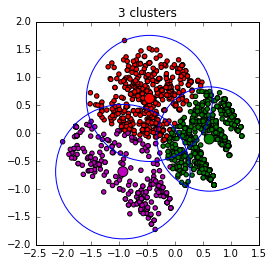

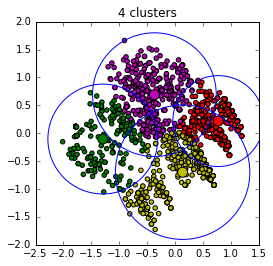

In [10]:
def P3():
    # PCA and fit with train data
    pca = PCA(n_components=2)
    pca.fit(train_data)
    
    # Transform train data using PCA
    proj_PCA_data = pca.transform(train_data)
    
    # 1 to 4 clusters graphs
    for i in range(4):  
        N = i + 1                                    # number of clusters
        km = KMeans (n_clusters=N, init='k-means++') # K-means clustering
        clstrs = km.fit(proj_PCA_data)               # fit projected 2D data
        distance = km.transform(proj_PCA_data)   # distance between points to each cluster center
    
        myColors = ('red', 'green', 'magenta', 'yellow')
    
        # To set colors for each cluster
        myClusterCols = np.empty(proj_PCA_data.shape[0], 'string')
        for index in np.arange(0, len(clstrs.labels_)):
            color_index = clstrs.labels_[index]
            myClusterCols[index] = myColors[color_index]

        # Scatter plot of the data points
        plt.figure(figsize = (4, 4))
        plt.scatter(proj_PCA_data[:,0], proj_PCA_data[:,1], c = myClusterCols)

        # To set colors of each center of the cluster in same color as the cluster color
        myCenterCol = np.empty(N, 'string')
        for ii in np.arange (0, N):
            color_index = ii
            myCenterCol[ii] = myColors[color_index]

        # To plot the center of each cluster
        #print myCenterCol
        plt.scatter(clstrs.cluster_centers_[:,0], clstrs.cluster_centers_[:,1], c = myCenterCol, s = 100)
        plt.title(str(N) + " clusters")
        
        # To plot a circle that goes from cluster center to the most distant point assigned to each cluster.
        for j in range(N):
            
            # Create an array with cluster labels and distances of points to center of cluster j
            PCAdata_with_clstrs = np.column_stack((clstrs.labels_, distance[:,j]))
            
            # Some info on cluster j
            circle_center = clstrs.cluster_centers_[j]  # x, y coordinate for center of cluster j
            center_x = circle_center[0]  # x coordinate for center of cluster j
            center_y = circle_center[1]  # y coordinate for center of cluster j
            PCAdata_in_cluster = PCAdata_with_clstrs[PCAdata_with_clstrs[:,0]==j]  # data in cluster j
            
            # Calculate distance between center of cluster and data point with coordinate x, y
            cluster_dist = [dist for label, dist in PCAdata_in_cluster]
            max_dist = max(cluster_dist)  # maximum for most distant point from center of cluster j
            
            # Plot the circle with center of cluster j and radius from most distant point from center
            circle1 = plt.Circle((center_x, center_y), radius=max_dist, color='blue', fill=False)
            fig = plt.gcf()
            ax = fig.gca()
            ax.add_artist(circle1)

        plt.show()
        

P3()

Observation: no obvious distinct clusters. All dropout mentors seem to be part of the same one giant cluster.

### 2. Gaussian Mixture Model (GMM)

Try clsutering using GMM - 

Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

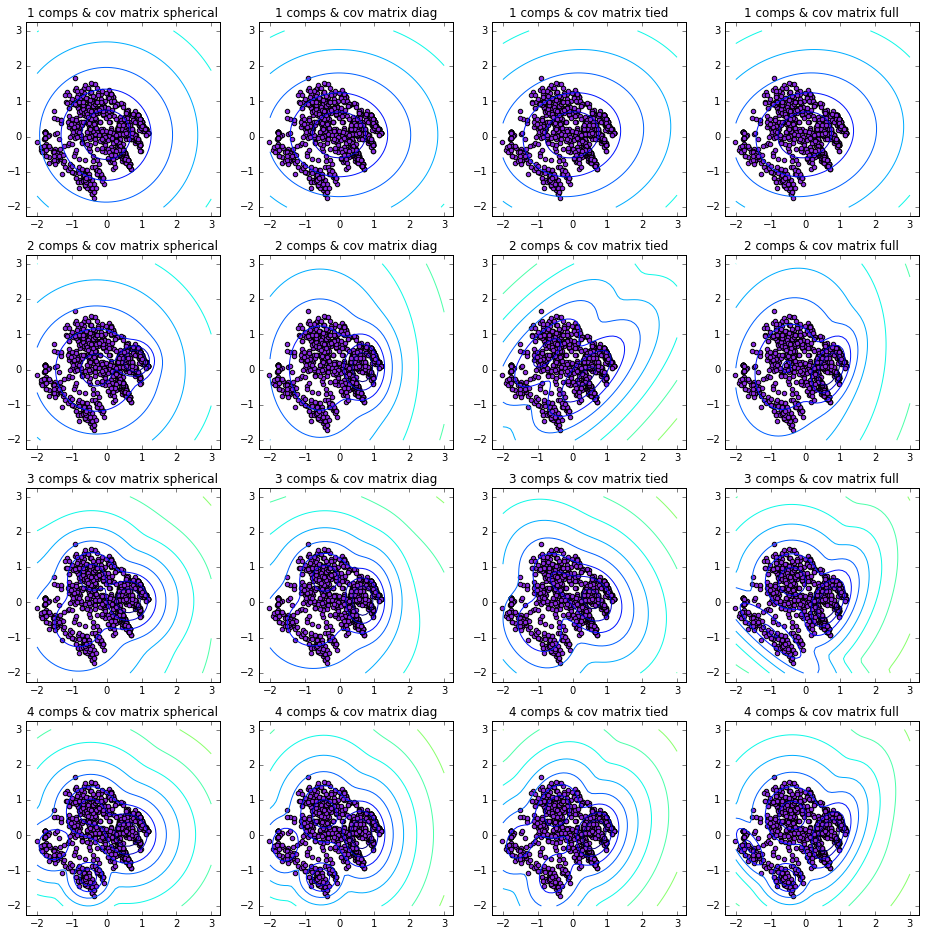

In [11]:
def P4():
    # PCA and fit with train data
    pca = PCA(n_components=2)
    pca.fit(train_data)
    
    # Transform train data using PCA
    proj_PCA_data = pca.transform(train_data)
    
    # Filter the positive examples (dropouts) in the projected 2D data
    proj_PCA_positive = proj_PCA_data[train_labels == 1]
    
    
    # Set plot with 4 graphs by 4 graphs
    f, axes = plt.subplots(nrows=4, ncols=4, figsize=(16,16))
    
    cov_types_list = ['spherical', 'diag', 'tied', 'full']  # covariance matrix types 
    
    for n in range(1,5):  # Fit a Gaussian Mixture Model with 1 to 4 components
        
        for i in range(4):  # Fit a Gaussian Mixture Model with 1 to 4 components
            cov_type = cov_types_list[i]
            clf = GMM(n_components=n, covariance_type=cov_type)
            clf.fit(proj_PCA_positive)

            # Display predicted scores by the model as a contour plot
            x = np.linspace(-2., 3.)
            y = np.linspace(-2., 3.)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -clf.score_samples(XX)[0]
            Z = Z.reshape(X.shape)
            
            ax = axes[n-1, i]
            CS = ax.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                             levels=np.logspace(0, 2, 10))
    
            # Plot the projected 2D data
            ax.scatter(proj_PCA_positive[:, 0], proj_PCA_positive[:, 1], c='blueviolet')
            ax.set_title(str(n) + ' comps & cov matrix ' + cov_type)
            ax.axis('tight')
    
    plt.show()


P4()

Observation: no clear observation of how many optimal GMM components to best represent the positive cluster.

### Prediction using GMM for both positive (dropout) and negative (formal closure) groups

Goal:  Predict the test mentors by choosing the label (dropout or formal closure) for which the model gives a larger probability. Evaluate model with its prediction accuracy.

Method: Fit 1-component full covariance GMMs model 2 times: one for the positive examples and one for the negative examples in the 2d projected data (PCA).

In [12]:
def P5():
    # PCA and fit with train data
    pca = PCA(n_components=2)
    pca.fit(train_data)
    
    # Transform train data using PCA
    proj_PCA_data = pca.transform(train_data)
    
    # Filter the positive examples in the projected 2D data
    proj_PCA_positive = proj_PCA_data[train_labels == 1]
    
    # Filter the negative examples in the projected 2D data
    proj_PCA_negative = proj_PCA_data[train_labels == 0]
    
    # Fit 4-component full covariance GMM for the positive examples
    gmm_positive = GMM(n_components=1, covariance_type='full')
    gmm_positive.fit(proj_PCA_positive)
    
    # Fit 4-component full covariance GMM for the negative examples
    gmm_negative = GMM(n_components=1, covariance_type='full')
    gmm_negative.fit(proj_PCA_negative)
    
    # Transform test data using PCA
    proj_PCA_test = pca.transform(test_data)
    
    # Compute the log probability under each positive and negative examples GMMs
    positive_score = gmm_positive.score(proj_PCA_test)
    negative_score = gmm_negative.score(proj_PCA_test)
    
    # Predict the test examples by choosing the label for which the model gives a larger probability
    # Positive label (1) if larger prob for positive examples GMM
    # Negative label (0) if smaller prob for positive examples GMM
    predicted_labels = (positive_score > negative_score) * 1.0
    
    # Compute accuracy based on number of predicted labels equal to test labels
    predicted_correct = (predicted_labels == test_labels) * 1.0  # 0 if predicted incorrectly and 1 if correctly
    predicted_correct_dropout = (predicted_labels == test_labels) * (predicted_labels == 1)
    correct_predicted_count = predicted_correct.sum()
    correct_predicted_dropout_count = predicted_correct_dropout.sum()
    correct_predicted_formal_count = correct_predicted_count- correct_predicted_dropout_count
    total_count = predicted_labels.shape[0]
    total_dropout_count = sum(predicted_labels)
    total_formal_count = total_count - total_dropout_count
    accuracy = correct_predicted_count/total_count
    accuracy_dropout = correct_predicted_dropout_count/total_dropout_count
    accuracy_formal = correct_predicted_formal_count/total_formal_count
    
    # Print results
    print "Total number of correctly predicted labels: %.0f" %(correct_predicted_count)
    print "\t- number of correctly predicted dropouts: %.0f" %(correct_predicted_dropout_count)
    print "\t- number of correctly predicted formal closure: %.0f" %(correct_predicted_formal_count)
    print "Total number of predicted labels: %.0f" %(total_count)
    print "\t- number of total dropouts: %0.f" %(total_dropout_count)
    print "\t- number of total formal closure: %0.f" %(total_formal_count)
    print "Accuracy: %.3f" %(accuracy)
    print "\t- accuracy of dropouts: %.3f" %(accuracy_dropout)
    print "\t- accuracy of formal closure: %.3f" %(accuracy_formal)

    
P5()

Total number of correctly predicted labels: 433
	- number of correctly predicted dropouts: 279
	- number of correctly predicted formal closure: 154
Total number of predicted labels: 766
	- number of total dropouts: 380
	- number of total formal closure: 386
Accuracy: 0.565
	- accuracy of dropouts: 0.734
	- accuracy of formal closure: 0.399


Observation: the accuracy is almost a coin toss chance: better for dropouts than for formal closure

### Prediction with GMM - Part 2 - Adjust number of parameters

Goal: Check model that gives the best accuracy with the fewest parameters 

Method: Run a series of experiments to find the model that gives the best accuracy with no more than 20 parameters. 
Vary the number of PCA components, the number of GMM components, and the covariance type.

In [13]:
def calculate_accuracy(PCA_comps, GMM_comps, cov_type):
    # PCA and fit with train data
    pca = PCA(n_components=PCA_comps)
    pca.fit(train_data)
    
    # Transform train data using PCA
    proj_PCA_data = pca.transform(train_data)
    
    # Filter the positive examples in the projected 2D data
    proj_PCA_positive = proj_PCA_data[train_labels == 1]
    
    # Filter the negative examples in the projected 2D data
    proj_PCA_negative = proj_PCA_data[train_labels == 0]
    
    # Fit 4-component full covariance GMM for the positive examples
    gmm_positive = GMM(n_components=GMM_comps, covariance_type=cov_type)
    gmm_positive.fit(proj_PCA_positive)
    
    # Fit 4-component full covariance GMM for the negative examples
    gmm_negative = GMM(n_components=GMM_comps, covariance_type=cov_type)
    gmm_negative.fit(proj_PCA_negative)
    
    # Transform test data using PCA
    proj_PCA_test = pca.transform(test_data)
    
    # Compute the log probability under each positive and negative examples GMMs
    positive_score = gmm_positive.score(proj_PCA_test)
    negative_score = gmm_negative.score(proj_PCA_test)
    
    # Predict the test examples by choosing the label for which the model gives a larger probability
    # Positive label (1) if larger prob for positive examples GMM
    # Negative label (0) if smaller prob for positive examples GMM
    predicted_labels = (positive_score > negative_score) * 1.0
    
    # Compute accuracy based on number of predicted labels equal to test labels
    predicted_correct = (predicted_labels == test_labels) * 1.0  # 0 if predicted incorrectly and 1 if correctly
    correct_predicted_count = predicted_correct.sum()
    total_count = predicted_labels.shape[0]
    accuracy = correct_predicted_count/total_count
    
    return accuracy

In [14]:
PCA_comps_list = list(range(1,20))
GMM_comps_list = list(range(1,20))
cov_types_list = ['spherical', 'diag', 'tied', 'full']

results = []

for n in PCA_comps_list:
    for m in GMM_comps_list:
        cov_count = 0
        for cov_type in cov_types_list:
            if cov_type == 'spherical':
                cov_count = 1
                parameter_count = (n + cov_count) * m * 2
            elif cov_type == 'diag':
                cov_count = n
                parameter_count = (n + cov_count) * m * 2
            elif cov_type == 'full':
                cov_count = n*(n-1)/2 + n
                parameter_count = (n + cov_count) * m * 2
            else:  # tied covaraince matrix type
                cov_count = n*(n-1)/2 + n
                parameter_count = ((n * m) + cov_count) * 2
                
            if parameter_count <= 20:
                accuracy = calculate_accuracy(n, m, cov_type)
                results.append([n, m, cov_type, parameter_count, accuracy])
                
results_sorted = sorted(results, key=lambda tup: tup[4], reverse=True)

for i in range(20):
    print "PCA comps:",results_sorted[i][0], "\tGMM comps:", results_sorted[i][1], "\tCov matrix:",\
    results_sorted[i][2], "\tNumber of param:", results_sorted[i][3], "\tAccuracy: %.4f" %(results_sorted[i][4])
    

PCA comps: 9 	GMM comps: 1 	Cov matrix: spherical 	Number of param: 20 	Accuracy: 0.7689
PCA comps: 8 	GMM comps: 1 	Cov matrix: spherical 	Number of param: 18 	Accuracy: 0.7637
PCA comps: 7 	GMM comps: 1 	Cov matrix: spherical 	Number of param: 16 	Accuracy: 0.7363
PCA comps: 6 	GMM comps: 1 	Cov matrix: spherical 	Number of param: 14 	Accuracy: 0.7232
PCA comps: 5 	GMM comps: 1 	Cov matrix: spherical 	Number of param: 12 	Accuracy: 0.7141
PCA comps: 5 	GMM comps: 1 	Cov matrix: diag 	Number of param: 20 	Accuracy: 0.7037
PCA comps: 4 	GMM comps: 1 	Cov matrix: diag 	Number of param: 16 	Accuracy: 0.6723
PCA comps: 4 	GMM comps: 1 	Cov matrix: spherical 	Number of param: 10 	Accuracy: 0.6684
PCA comps: 4 	GMM comps: 2 	Cov matrix: spherical 	Number of param: 20 	Accuracy: 0.6580
PCA comps: 2 	GMM comps: 3 	Cov matrix: tied 	Number of param: 18 	Accuracy: 0.6332
PCA comps: 3 	GMM comps: 1 	Cov matrix: tied 	Number of param: 18 	Accuracy: 0.6201
PCA comps: 3 	GMM comps: 1 	Cov matrix: f

Observation: accuracy of 75%+ for PCA components >=8 and GMM component =1. Try prediction again with these components instead of 2 PCA component and 1 GMM component

In [15]:
def P7():
    # PCA and fit with train data
    pca = PCA(n_components=8)
    pca.fit(train_data)
    
    # Transform train data using PCA
    proj_PCA_data = pca.transform(train_data)
    
    # Filter the positive examples in the projected 2D data
    proj_PCA_positive = proj_PCA_data[train_labels == 1]
    
    # Filter the negative examples in the projected 2D data
    proj_PCA_negative = proj_PCA_data[train_labels == 0]
    
    # Fit 4-component full covariance GMM for the positive examples
    gmm_positive = GMM(n_components=1, covariance_type='full')
    gmm_positive.fit(proj_PCA_positive)
    
    # Fit 4-component full covariance GMM for the negative examples
    gmm_negative = GMM(n_components=1, covariance_type='full')
    gmm_negative.fit(proj_PCA_negative)
    
    # Transform test data using PCA
    proj_PCA_test = pca.transform(test_data)
    
    # Compute the log probability under each positive and negative examples GMMs
    positive_score = gmm_positive.score(proj_PCA_test)
    negative_score = gmm_negative.score(proj_PCA_test)
    
    # Predict the test examples by choosing the label for which the model gives a larger probability
    # Positive label (1) if larger prob for positive examples GMM
    # Negative label (0) if smaller prob for positive examples GMM
    predicted_labels = (positive_score > negative_score) * 1.0
    
    # Compute accuracy based on number of predicted labels equal to test labels
    predicted_correct = (predicted_labels == test_labels) * 1.0  # 0 if predicted incorrectly and 1 if correctly
    predicted_correct_dropout = (predicted_labels == test_labels) * (predicted_labels == 1)
    correct_predicted_count = predicted_correct.sum()
    correct_predicted_dropout_count = predicted_correct_dropout.sum()
    correct_predicted_formal_count = correct_predicted_count- correct_predicted_dropout_count
    total_count = predicted_labels.shape[0]
    total_dropout_count = sum(predicted_labels)
    total_formal_count = total_count - total_dropout_count
    accuracy = correct_predicted_count/total_count
    accuracy_dropout = correct_predicted_dropout_count/total_dropout_count
    accuracy_formal = correct_predicted_formal_count/total_formal_count
    
    # Print results
    print "Total number of correctly predicted labels: %.0f" %(correct_predicted_count)
    print "\t- number of correctly predicted dropouts: %.0f" %(correct_predicted_dropout_count)
    print "\t- number of correctly predicted formal closure: %.0f" %(correct_predicted_formal_count)
    print "Total number of predicted labels: %.0f" %(total_count)
    print "\t- number of total dropouts: %0.f" %(total_dropout_count)
    print "\t- number of total formal closure: %0.f" %(total_formal_count)
    print "Accuracy: %.3f" %(accuracy)
    print "\t- accuracy of dropouts: %.3f" %(accuracy_dropout)
    print "\t- accuracy of formal closure: %.3f" %(accuracy_formal)
    

    
P7()

Total number of correctly predicted labels: 614
	- number of correctly predicted dropouts: 413
	- number of correctly predicted formal closure: 201
Total number of predicted labels: 766
	- number of total dropouts: 467
	- number of total formal closure: 299
Accuracy: 0.802
	- accuracy of dropouts: 0.884
	- accuracy of formal closure: 0.672


Observation: the accuracy improved with higher PCA components (8 instead of 2).

## Relation analysis between demographic attributes

### Correlation matrix

Note: Selecting features based on their correlation with the output and eliminating features based on their correlation with each other will help us create a parsimonious model. Perhaps, it will help increase prediction accuracy further as well.

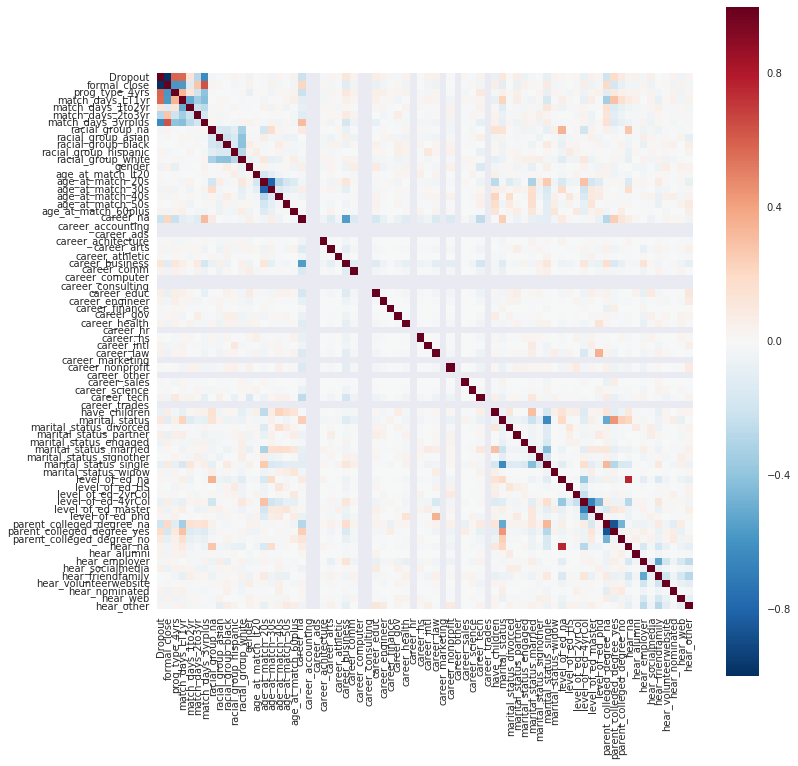

In [114]:
import seaborn as sns
# Calculate the correlation matrix - pairwise correlation
mentors_df2 = mentors_df.copy()
del mentors_df2['mentor_persona_id']
cm = mentors_df2.corr()
plt.figure(figsize=(12,12))
sns.heatmap(cm, square=True)
plt.yticks(rotation=0)
a= plt.xticks(rotation=90)
plt.savefig('correlation_matrix.png')

Observation: the program type or match days complement each other - so only one should be used. Will be using program type since match days is quite trivial to predict a dropout or formal closure (dropout will have a shorter number of match period than formal closure)

### Chi square test of independence

In [116]:
from scipy.stats import chi2_contingency

def chisq_of_df_cols(df, c1, c2):
    groupsizes = df.groupby([c1, c2]).size()
    ctsum = groupsizes.unstack(c1)
    # fillna(0) is necessary to remove any NAs which will cause exceptions
    return(chi2_contingency(ctsum.fillna(0)))

In [117]:
attributes = ['prog_type_4yrs',\
 'racial_group_na' ,'racial_group_asian',\
 'racial_group_black', 'racial_group_hispanic', 'racial_group_white' ,'gender',\
 'age_at_match_lt20', 'age_at_match_20s' ,'age_at_match_30s',\
 'age_at_match_40s' ,'age_at_match_50s' ,'age_at_match_60plus', 'career_na',\
 'career_accounting' ,'career_ads' ,'career_achitecture', 'career_arts',\
 'career_athletic' ,'career_business' ,'career_comm', 'career_computer',\
 'career_consulting' ,'career_educ' ,'career_engineer' ,'career_finance',\
 'career_gov', 'career_health' ,'career_hr' ,'career_hs' ,'career_intl',\
 'career_law' ,'career_marketing' ,'career_nonprofit', 'career_other',\
 'career_sales' ,'career_science', 'career_tech', 'career_trades',\
 'have_children', 'marital_status' ,'marital_status_divorced',\
 'marital_status_partner' ,'marital_status_engaged', 'marital_status_married',\
 'marital_status_signother' ,'marital_status_single', 'marital_status_widow',\
 'level_of_ed_na' ,'level_of_ed_HS' ,'level_of_ed_2yrCol',\
 'level_of_ed_4yrCol' ,'level_of_ed_master', 'level_of_ed_phd',\
 'parent_colleged_degree_yes', 'parent_colleged_degree_yes.1',\
 'parent_colleged_degree_yes.2', 'hear_na' ,'hear_alumni', 'hear_employer',\
 'hear_socialmedia' ,'hear_friendfamily', 'hear_volunteerwebsite',\
 'hear_nominated' ,'hear_web', 'hear_other']

features_list = []
for attribute in attributes:
    chi2, p, dof, ex = chisq_of_df_cols(mentors_df2, 'Dropout', attribute)
    features_list.append([attribute, chi2, p])
    print "\nAttribute:", attribute
    print "Chi2: %.2f" %(chi2), "\tp: %.4f" %(p), "\tDF:", dof


Attribute: prog_type_4yrs
Chi2: 777.10 	p: 0.0000 	DF: 1

Attribute: racial_group_na
Chi2: 1.22 	p: 0.2693 	DF: 1

Attribute: racial_group_asian
Chi2: 0.31 	p: 0.5801 	DF: 1

Attribute: racial_group_black
Chi2: 0.00 	p: 0.9923 	DF: 1

Attribute: racial_group_hispanic
Chi2: 1.53 	p: 0.2157 	DF: 1

Attribute: racial_group_white
Chi2: 0.16 	p: 0.6871 	DF: 1

Attribute: gender
Chi2: 6.18 	p: 0.0455 	DF: 2

Attribute: age_at_match_lt20
Chi2: 0.04 	p: 0.8350 	DF: 1

Attribute: age_at_match_20s
Chi2: 0.28 	p: 0.5960 	DF: 1

Attribute: age_at_match_30s
Chi2: 3.02 	p: 0.0822 	DF: 1

Attribute: age_at_match_40s
Chi2: 1.52 	p: 0.2183 	DF: 1

Attribute: age_at_match_50s
Chi2: 0.01 	p: 0.9385 	DF: 1

Attribute: age_at_match_60plus
Chi2: 2.63 	p: 0.1046 	DF: 1

Attribute: career_na
Chi2: 105.10 	p: 0.0000 	DF: 1

Attribute: career_accounting
Chi2: 0.00 	p: 1.0000 	DF: 0

Attribute: career_ads
Chi2: 0.00 	p: 1.0000 	DF: 0

Attribute: career_achitecture
Chi2: 0.14 	p: 0.7078 	DF: 1

Attribute: career

KeyError: 'parent_colleged_degree_yes.1'

In [120]:
significant_features = []
for feature in features_list:
    if feature[2] <= 0.05:
        significant_features.append(feature[0])
print significant_features

['prog_type_4yrs', 'gender', 'career_na', 'career_business', 'career_comm', 'career_educ', 'career_law', 'have_children', 'marital_status', 'marital_status_partner', 'marital_status_engaged', 'marital_status_single', 'level_of_ed_4yrCol', 'level_of_ed_master', 'parent_colleged_degree_yes']


### Indepedent t-test for continuous features

Check if continuous attribute mean of formal closure group and dropout groups are significantly different

In [118]:
import scipy.stats as ss
cont_attributes = ['prog_type_4yrs',\
 'racial_group_na' ,'racial_group_asian',\
 'racial_group_black', 'racial_group_hispanic', 'racial_group_white' ,'gender',\
 'age_at_match_lt20', 'age_at_match_20s' ,'age_at_match_30s',\
 'age_at_match_40s' ,'age_at_match_50s' ,'age_at_match_60plus', 'career_na',\
 'career_accounting' ,'career_ads' ,'career_achitecture', 'career_arts',\
 'career_athletic' ,'career_business' ,'career_comm', 'career_computer',\
 'career_consulting' ,'career_educ' ,'career_engineer' ,'career_finance',\
 'career_gov', 'career_health' ,'career_hr' ,'career_hs' ,'career_intl',\
 'career_law' ,'career_marketing' ,'career_nonprofit', 'career_other',\
 'career_sales' ,'career_science', 'career_tech', 'career_trades',\
 'have_children', 'marital_status' ,'marital_status_divorced',\
 'marital_status_partner' ,'marital_status_engaged', 'marital_status_married',\
 'marital_status_signother' ,'marital_status_single', 'marital_status_widow',\
 'level_of_ed_na' ,'level_of_ed_HS' ,'level_of_ed_2yrCol',\
 'level_of_ed_4yrCol' ,'level_of_ed_master', 'level_of_ed_phd',\
 'parent_colleged_degree_yes', 'parent_colleged_degree_yes.1',\
 'parent_colleged_degree_yes.2', 'hear_na', 'hear_alumni', 'hear_employer',\
 'hear_socialmedia' ,'hear_friendfamily', 'hear_volunteerwebsite',\
 'hear_nominated' ,'hear_web', 'hear_other']

cont_features_list = []
for attribute in cont_attributes:
    cat1 = mentors_df2[mentors_df2['Dropout']==0]
    cat2 = mentors_df2[mentors_df2['Dropout']==1]
    meancat1 = cat1[attribute].mean()
    meancat2 = cat2[attribute].mean()
    t_stat, p_value = ss.ttest_ind(cat1[attribute], cat2[attribute])
    cont_features_list.append([attribute, t_stat, p_value])
    print "Attribute:", attribute
    print "Mean for formal closure: %.1f" %(meancat1), " and mean for dropout: %.1f" %(meancat2)
    print "t-stat: %.4f" %(t_stat), "and p-value: %.4f" %(p_value)

Attribute: prog_type_4yrs
Mean for formal closure: 0.2  and mean for dropout: 0.8
t-stat: -34.3421 and p-value: 0.0000
Attribute: racial_group_na
Mean for formal closure: 0.1  and mean for dropout: 0.1
t-stat: 1.1720 and p-value: 0.2413
Attribute: racial_group_asian
Mean for formal closure: 0.2  and mean for dropout: 0.2
t-stat: 0.6106 and p-value: 0.5415
Attribute: racial_group_black
Mean for formal closure: 0.2  and mean for dropout: 0.2
t-stat: -0.0476 and p-value: 0.9620
Attribute: racial_group_hispanic
Mean for formal closure: 0.1  and mean for dropout: 0.1
t-stat: -1.3149 and p-value: 0.1887
Attribute: racial_group_white
Mean for formal closure: 0.4  and mean for dropout: 0.4
t-stat: -0.4469 and p-value: 0.6550
Attribute: gender
Mean for formal closure: 0.5  and mean for dropout: 0.5
t-stat: 1.9438 and p-value: 0.0520
Attribute: age_at_match_lt20
Mean for formal closure: 0.0  and mean for dropout: 0.0
t-stat: -0.3633 and p-value: 0.7164
Attribute: age_at_match_20s
Mean for formal

KeyError: 'parent_colleged_degree_yes.1'

In [119]:
significant_features_cont = []
for feature in cont_features_list:
    if feature[2] <= 0.05:
        significant_features_cont.append(feature[0])
print significant_features_cont

['prog_type_4yrs', 'career_na', 'career_business', 'career_comm', 'career_educ', 'career_health', 'career_law', 'have_children', 'marital_status', 'marital_status_partner', 'marital_status_engaged', 'marital_status_single', 'level_of_ed_4yrCol', 'level_of_ed_master', 'parent_colleged_degree_yes']


### Correlation matrix - retake

This time, with only statistically significant features only

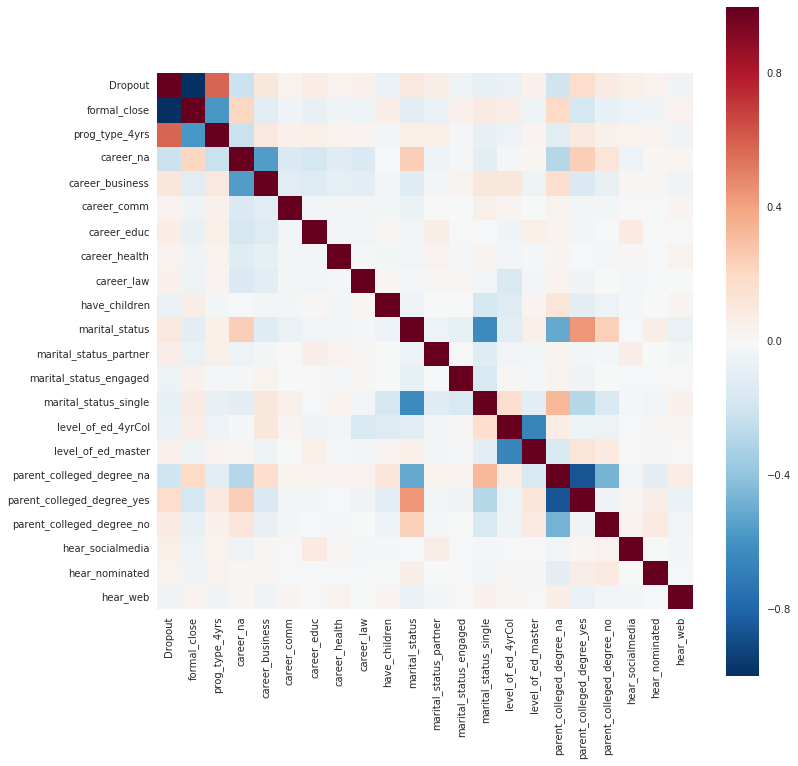

In [122]:
import seaborn as sns
# Calculate the correlation matrix - pairwise correlation
mentors_df3 = mentors_df.copy()
del mentors_df3['mentor_persona_id']

attributes = cont_attributes = ['match_days_LT1yr' ,'match_days_1to2yr' ,'match_days_2to3yr',\
 'match_days_3yrplus','racial_group_na' ,'racial_group_asian',\
 'racial_group_black', 'racial_group_hispanic', 'racial_group_white' ,'gender',\
 'age_at_match_lt20', 'age_at_match_20s' ,'age_at_match_30s',\
 'age_at_match_40s' ,'age_at_match_50s' ,'age_at_match_60plus',\
 'career_accounting' ,'career_ads' ,'career_achitecture', 'career_arts',\
 'career_athletic' , 'career_computer',\
 'career_consulting' ,'career_engineer' ,'career_finance',\
 'career_gov' ,'career_hr' ,'career_hs' ,'career_intl',\
 'career_marketing' ,'career_nonprofit', 'career_other',\
 'career_sales' ,'career_science', 'career_tech', 'career_trades',\
 'marital_status_divorced',\
 'marital_status_married',\
 'marital_status_signother', 'marital_status_widow',\
 'level_of_ed_na' ,'level_of_ed_HS' ,'level_of_ed_2yrCol',\
 'level_of_ed_phd',\
 'hear_na', 'hear_alumni', 'hear_employer',\
 'hear_friendfamily', 'hear_volunteerwebsite','hear_other']

for attribute in attributes:
    del mentors_df3[attribute]

cm = mentors_df3.corr()
plt.figure(figsize=(12,12))
sns.heatmap(cm, square=True)
plt.yticks(rotation=0)
a= plt.xticks(rotation=90)
plt.savefig('correlation_matrix.png')

In [17]:
print mentors_df.columns.values


['mentor_persona_id' 'Dropout' 'formal_close' 'prog_type_4yrs'
 'match_days_LT1yr' 'match_days_1to2yr' 'match_days_2to3yr'
 'match_days_3yrplus' 'racial_group_na' 'racial_group_asian'
 'racial_group_black' 'racial_group_hispanic' 'racial_group_white' 'gender'
 'age_at_match_lt20' 'age_at_match_20s' 'age_at_match_30s'
 'age_at_match_40s' 'age_at_match_50s' 'age_at_match_60plus' 'career_na'
 'career_accounting' 'career_ads' 'career_achitecture' 'career_arts'
 'career_athletic' 'career_business' 'career_comm' 'career_computer'
 'career_consulting' 'career_educ' 'career_engineer' 'career_finance'
 'career_gov' 'career_health' 'career_hr' 'career_hs' 'career_intl'
 'career_law' 'career_marketing' 'career_nonprofit' 'career_other'
 'career_sales' 'career_science' 'career_tech' 'career_trades'
 'have_children' 'marital_status' 'marital_status_divorced'
 'marital_status_partner' 'marital_status_engaged' 'marital_status_married'
 'marital_status_signother' 'marital_status_single' 'marital_statu

## Prediction algorithm

### All features included (no feature selection)

In [18]:
# Randomly shuffle the training data. Use same random seed to get same results every time.
mentors_df4 = mentors_df.copy()  # all features
train_df_shuffle = mentors_df4.sample(frac=1, random_state=0).reset_index(drop=True)

# Separate train labels
train_labels = [i for i in train_df_shuffle.Dropout]

# Drop labels from train data
train_df_shuffle.drop('Dropout', axis=1, inplace=True)
train_df_shuffle.drop('formal_close', axis=1, inplace=True)
train_df_shuffle.drop('mentor_persona_id', axis=1, inplace=True)
train_df_shuffle.drop('match_days_LT1yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_1to2yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_2to3yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_3yrplus', axis=1, inplace=True)
    

# Split the train data into training and dev datasets - about 2/3 & 1/3
# Total observations in mentors_df = 2,296
training_df =  train_df_shuffle[:1530]
dev_df = train_df_shuffle[1530:]

# Separate training and dev labels
training_labels =  train_labels[:1530]
dev_labels = train_labels[1530:]

In [25]:
import time

# Import libraries for classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier 

# Import sklearn utility libraries
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV

# Import libraries to assess goodness of fit
from sklearn.metrics import classification_report
from sklearn import metrics
import scipy.stats as ss  # for independent t-test

### Decision Tree

In [20]:
# Decision Tree
print "Evaluating Decision Tree model ..."

# Create a Decision Tree model. 
DTmodel = DecisionTreeClassifier(criterion='entropy', max_depth=5)

# Fit the models and display the results.
start_time = time.time()
DTmodel.fit(training_df, training_labels)
end_time = time.time()
print "Decistion Tree model fitting time = %f seconds." % (end_time - start_time)

# Predict labels for dev data and calculate accuracy 
start_time = time.time()
yDTmodel = DTmodel.predict(dev_df)
end_time = time.time()
print "Decision Tree prediction time for dev data = %f seconds." % (end_time - start_time)

# Print goodness of fit measures
print "Accuracy on dev data for Decision Tree is = %f" % DTmodel.score(dev_df, dev_labels)
print "Classification Report\n", classification_report(dev_labels, yDTmodel)

Evaluating Decision Tree model ...
Decistion Tree model fitting time = 0.011910 seconds.
Decision Tree prediction time for dev data = 0.001648 seconds.
Accuracy on dev data for Decision Tree is = 0.817232
Classification Report
             precision    recall  f1-score   support

          0       0.69      0.81      0.75       255
          1       0.90      0.82      0.86       511

avg / total       0.83      0.82      0.82       766



In [35]:
features_importance = DTmodel.feature_importances_ 
features_names = training_df.columns.values
features_imp_list = []
for name, importance in zip(features_names, features_importance):
    features_imp_list.append([name,importance])
    
features_imp_list_sorted = sorted(features_imp_list, key=lambda x: x[1], reverse=True)

for name, importance in features_imp_list_sorted:
    print name, ": %.4f" %(importance)

prog_type_4yrs : 0.6985
parent_colleged_degree_na : 0.1178
career_na : 0.0403
racial_group_asian : 0.0221
gender : 0.0201
racial_group_black : 0.0179
level_of_ed_na : 0.0134
marital_status_single : 0.0118
hear_web : 0.0094
marital_status_signother : 0.0085
career_health : 0.0082
hear_other : 0.0070
career_science : 0.0058
hear_friendfamily : 0.0058
marital_status : 0.0051
career_law : 0.0046
career_tech : 0.0038
racial_group_na : 0.0000
racial_group_hispanic : 0.0000
racial_group_white : 0.0000
age_at_match_lt20 : 0.0000
age_at_match_20s : 0.0000
age_at_match_30s : 0.0000
age_at_match_40s : 0.0000
age_at_match_50s : 0.0000
age_at_match_60plus : 0.0000
career_accounting : 0.0000
career_ads : 0.0000
career_achitecture : 0.0000
career_arts : 0.0000
career_athletic : 0.0000
career_business : 0.0000
career_comm : 0.0000
career_computer : 0.0000
career_consulting : 0.0000
career_educ : 0.0000
career_engineer : 0.0000
career_finance : 0.0000
career_gov : 0.0000
career_hr : 0.0000
career_hs : 

Output: dropouts-decisiontree.jpg


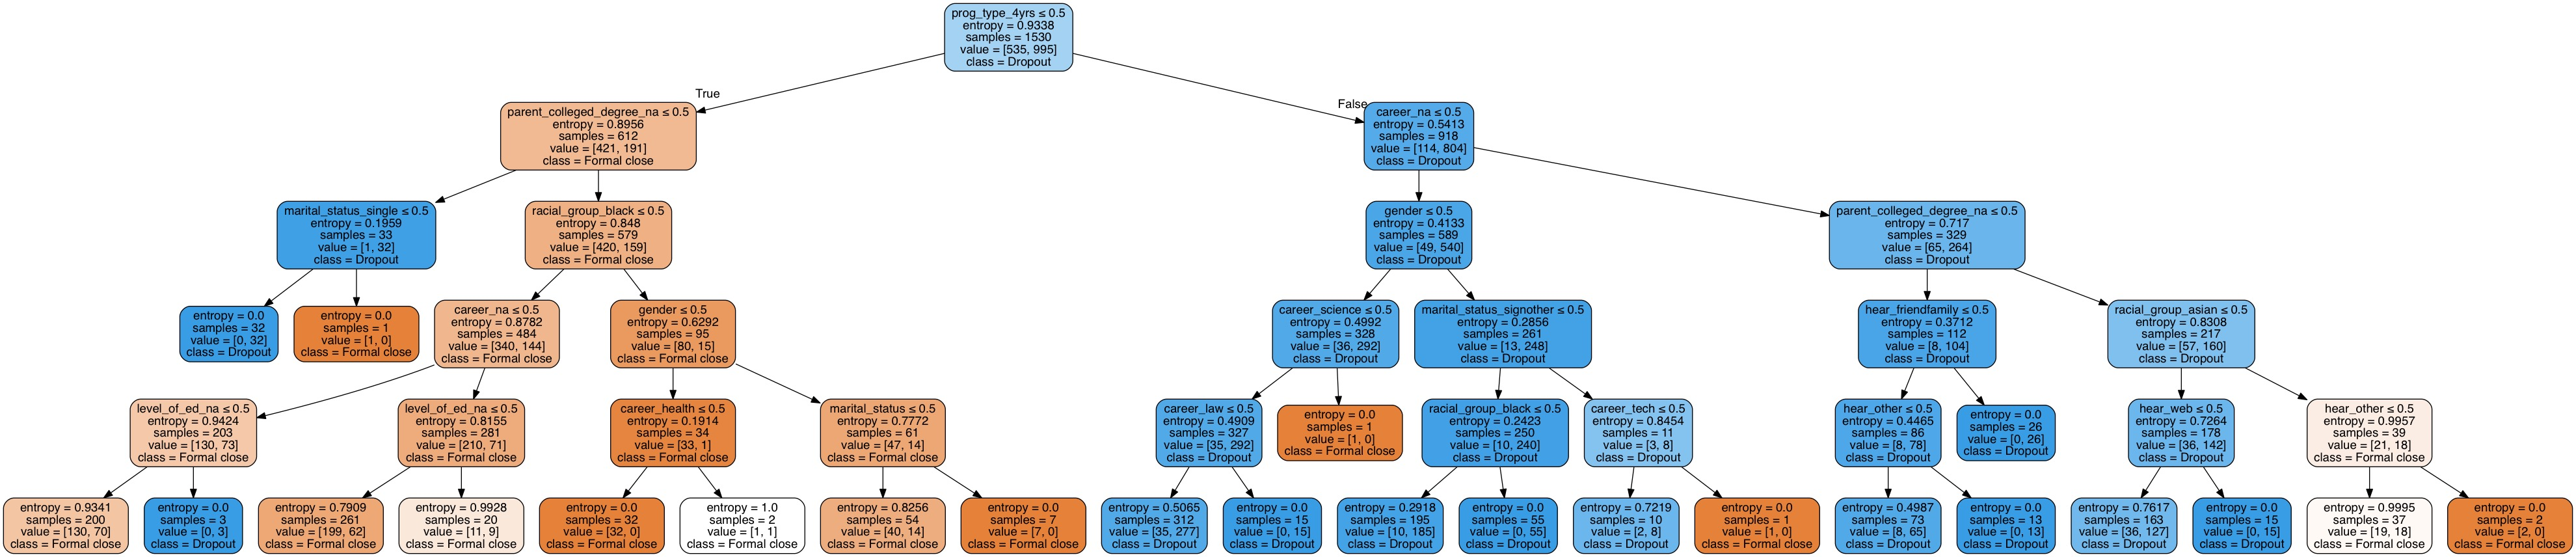

In [36]:
from IPython.core.display import Image, display
from sklearn.externals.six import StringIO
from sklearn import tree
import pydotplus 

features_list = training_df.columns.values
dropout_list = ['Formal close', 'Dropout']

# Export the trained tree so we can look at it.
output_name = 'dropouts-decisiontree.jpg'
dot_data = StringIO()
tree.export_graphviz(DTmodel, out_file=dot_data, feature_names=features_list, class_names=dropout_list, \
                     filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# If the export was successful, show the image.
if graph.write_jpg(output_name):
    print 'Output:', output_name
    display(Image(filename=output_name))  

### Logistic Regression

In [23]:
# Logistic Regression:
print "Evaluating Logistic Regression model ..."

# Create a Logistic Regression model. 
LRmodel = LogisticRegression(C=1.0)

# Create a grid search.
print "Performing grid search for Logistic Regression model. It may take a few minutes ..."
Cs = {'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]}
CV_LRmodel = GridSearchCV(estimator=LRmodel, param_grid=Cs)

# Fit the models using grid search and display the results.
start_time = time.time()
CV_LRmodel.fit(training_df, training_labels)
end_time = time.time()
print "Logistic Regression grid search model fitting time = %f seconds." % (end_time - start_time)

optimal_Cs = CV_LRmodel.best_params_['C']
print "As per the grid search on the training data, the optimal value of C = %f." % optimal_Cs

# Predict labels for dev data and calculate accuracy using optimal C
start_time = time.time()
yLRmodel = CV_LRmodel.predict(dev_df)
end_time = time.time()
print "Logistic prediction time for dev data = %f seconds." % (end_time - start_time)

# Print goodness of fit measures
print "Accuracy of Logistic Regression on dev data is = %f" % CV_LRmodel.score(dev_df, dev_labels)
print "Classification Report\n", classification_report(dev_labels, yLRmodel)

Evaluating Logistic Regression model ...
Performing grid search for Logistic Regression model. It may take a few minutes ...
Logistic Regression grid search model fitting time = 0.523455 seconds.
As per the grid search on the training data, the optimal value of C = 0.100000.
Logistic prediction time for dev data = 0.000912 seconds.
Accuracy of Logistic Regression on dev data is = 0.815927
Classification Report
             precision    recall  f1-score   support

          0       0.71      0.75      0.73       255
          1       0.87      0.85      0.86       511

avg / total       0.82      0.82      0.82       766



### Bernoulli Naive Bayes

In [37]:
# Bernoulli Naive Bayes:
print "Evaluating Bernoulli Naive Bayes model ..."

# Create a Bernoulli Naive Bayes model. 
GNBmodel = BernoulliNB()

# Fit the models using grid search and display the results.
start_time = time.time()
GNBmodel.fit(training_df, training_labels)
end_time = time.time()
print "Bernoulli Naive Bayes grid search model fitting time = %f seconds." % (end_time - start_time)


# Predict labels for dev data and calculate accuracy
start_time = time.time()
yGNBmodel = GNBmodel.predict(dev_df)
end_time = time.time()
print "Bernoulli Naive Bayes prediction time for dev data = %f seconds." % (end_time - start_time)

# Print goodness of fit measures
print "Accuracy of Bernoulli Naive Bayes on dev data is = %f" % GNBmodel.score(dev_df, dev_labels)
print "Classification Report\n", classification_report(dev_labels, yGNBmodel) 

Evaluating Bernoulli Naive Bayes model ...
Bernoulli Naive Bayes grid search model fitting time = 0.086617 seconds.
Bernoulli Naive Bayes prediction time for dev data = 0.011719 seconds.
Accuracy of Bernoulli Naive Bayes on dev data is = 0.809399
Classification Report
             precision    recall  f1-score   support

          0       0.71      0.72      0.71       255
          1       0.86      0.86      0.86       511

avg / total       0.81      0.81      0.81       766



## Classification model for each program type (4 years and 3 years)

In [38]:
mentors_df5 = mentors_df.copy()  # all features
mentors_df5_4yrs = mentors_df5[mentors_df5.prog_type_4yrs==1]
mentors_df5_3yrs = mentors_df5[mentors_df5.prog_type_4yrs==0]
print mentors_df5_4yrs.shape
print mentors_df5_3yrs.shape

(1386, 73)
(910, 73)


In [39]:
# For 4 years program
# Randomly shuffle the training data. Use same random seed to get same results every time.
train_df_shuffle = mentors_df5_4yrs.sample(frac=1, random_state=0).reset_index(drop=True)

# Separate train labels
train_labels = [i for i in train_df_shuffle.Dropout]

# Drop labels from train data
train_df_shuffle.drop('Dropout', axis=1, inplace=True)
train_df_shuffle.drop('formal_close', axis=1, inplace=True)
train_df_shuffle.drop('mentor_persona_id', axis=1, inplace=True)
train_df_shuffle.drop('prog_type_4yrs', axis=1, inplace=True)
train_df_shuffle.drop('match_days_LT1yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_1to2yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_2to3yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_3yrplus', axis=1, inplace=True)
    

# Split the train data into training and dev datasets - about 2/3 & 1/3
# Total observations in mentors_df = 1,386
training_df_4yrs =  train_df_shuffle[:925]
dev_df_4yrs = train_df_shuffle[925:]

# Separate training and dev labels
training_labels_4yrs =  train_labels[:925]
dev_labels_4yrs = train_labels[925:]

In [62]:
print "Number of dropouts in training data:", sum(training_labels_4yrs), "for total mentors of:", len(training_labels_4yrs)
print "Number of dropouts in dev data:", sum(dev_labels_4yrs), "for total mentors of:", len(dev_labels_4yrs)

Number of dropouts in training data: 821 for total mentors of: 925
Number of dropouts in dev data: 399 for total mentors of: 461


Observations:  
- Most are dropout mentors in the 4 year program, thus not enough data points for formal closure for an accurate prediction of formal closure.
- 88% dropout (1220 dropout and 166 formal closure)

In [44]:
# For 3 years program
# Randomly shuffle the training data. Use same random seed to get same results every time.
train_df_shuffle = mentors_df5_3yrs.sample(frac=1, random_state=0).reset_index(drop=True)

# Separate train labels
train_labels = [i for i in train_df_shuffle.Dropout]

# Drop labels from train data
train_df_shuffle.drop('Dropout', axis=1, inplace=True)
train_df_shuffle.drop('formal_close', axis=1, inplace=True)
train_df_shuffle.drop('mentor_persona_id', axis=1, inplace=True)
train_df_shuffle.drop('prog_type_4yrs', axis=1, inplace=True)
train_df_shuffle.drop('match_days_LT1yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_1to2yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_2to3yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_3yrplus', axis=1, inplace=True)
    

# Split the train data into training and dev datasets - about 2/3 & 1/3
# Total observations in mentors_df = 910
training_df_3yrs =  train_df_shuffle[:605]
dev_df_3yrs = train_df_shuffle[605:]

# Separate training and dev labels
training_labels_3yrs =  train_labels[:605]
dev_labels_3yrs = train_labels[605:]

In [63]:
print "Number of dropouts in training data:", sum(training_labels_3yrs), "for total mentors of:",len(training_labels_3yrs)
print "Number of dropouts in dev data:",sum(dev_labels_3yrs), "for total mentors of:",len(dev_labels_3yrs)

Number of dropouts in training data: 188 for total mentors of: 605
Number of dropouts in dev data: 98 for total mentors of: 305


Observations:  
- about only one out 4 mentors in the 3 year program dropped out, thus not enough data points for an accurate prediction of formal closure (exact opposite case of program of 4 years).
- 31% dropout (286 dropout and 624 formal closure)

### a) Decision Tree for 4 yrs program mentors

In [48]:
# Decision Tree
print "Evaluating Decision Tree model ..."

# Create a Decision Tree model. 
DTmodel = DecisionTreeClassifier(criterion='entropy', max_depth=5)

# Fit the models and display the results.
start_time = time.time()
DTmodel.fit(training_df_4yrs, training_labels_4yrs)
end_time = time.time()
print "Decistion Tree model fitting time = %f seconds." % (end_time - start_time)

# Predict labels for dev data and calculate accuracy 
start_time = time.time()
yDTmodel = DTmodel.predict(dev_df_4yrs)
end_time = time.time()
print "Decision Tree prediction time for dev data = %f seconds." % (end_time - start_time)

# Print goodness of fit measures
print "Accuracy on dev data for Decision Tree is = %f" % DTmodel.score(dev_df_4yrs, dev_labels_4yrs)
print "Classification Report\n", classification_report(dev_labels_4yrs, yDTmodel)

Evaluating Decision Tree model ...
Decistion Tree model fitting time = 0.004329 seconds.
Decision Tree prediction time for dev data = 0.001035 seconds.
Accuracy on dev data for Decision Tree is = 0.863341
Classification Report
             precision    recall  f1-score   support

          0       0.46      0.10      0.16        62
          1       0.88      0.98      0.93       399

avg / total       0.82      0.86      0.82       461



Observation: as suspected, the accuracy of formal closure is very low due to small data points. Thus, this model should not be used since unreliable.

### b) Decision Tree for 3 yrs program mentors

In [54]:
# Decision Tree
print "Evaluating Decision Tree model ..."

# Create a Decision Tree model. 
DTmodel = DecisionTreeClassifier(criterion='entropy', max_depth=6)

# Fit the models and display the results.
start_time = time.time()
DTmodel.fit(training_df_3yrs, training_labels_3yrs)
end_time = time.time()
print "Decistion Tree model fitting time = %f seconds." % (end_time - start_time)

# Predict labels for dev data and calculate accuracy 
start_time = time.time()
yDTmodel = DTmodel.predict(dev_df_3yrs)
end_time = time.time()
print "Decision Tree prediction time for dev data = %f seconds." % (end_time - start_time)

# Print goodness of fit measures
print "Accuracy on dev data for Decision Tree is = %f" % DTmodel.score(dev_df_3yrs, dev_labels_3yrs)
print "Classification Report\n", classification_report(dev_labels_3yrs, yDTmodel)

Evaluating Decision Tree model ...
Decistion Tree model fitting time = 0.004493 seconds.
Decision Tree prediction time for dev data = 0.001037 seconds.
Accuracy on dev data for Decision Tree is = 0.721311
Classification Report
             precision    recall  f1-score   support

          0       0.72      0.97      0.82       207
          1       0.74      0.20      0.32        98

avg / total       0.73      0.72      0.66       305



Observation: as suspected, the accuracy of dropout is very low due to small data points. Thus, this model is not a reliable one.

### Conclusion for prediction per group

In case of building a decision tree model for each type of program and using only demographic attributes is not appropriate to predict the dropout of mentors.

In [87]:
# Load the data
match_df = pd.read_csv('match_days.csv')
print match_df.shape

(6644, 5)


In [88]:
# Filter out mentor dropout and mentor formal closure to compare these 2 groups only
match_df = match_df[(match_df.formal_close==1) | (match_df.Dropout==1)]
print match_df.shape

(2296, 5)


In [91]:
match_4yrs = match_df[match_df.prog_type_4yrs==1]
match_3yrs = match_df[match_df.prog_type_4yrs==0]

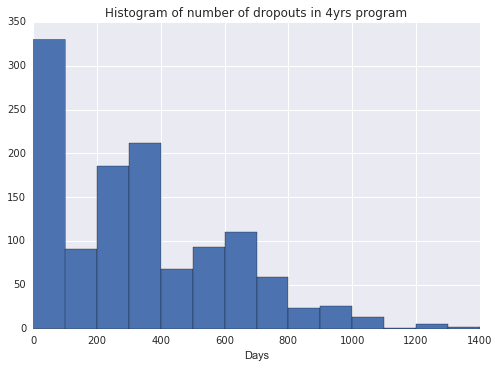

In [111]:
match_4yrs[match_4yrs.Dropout==1].length_of_match_in_days.hist(bins=14, range=[0, 1400])
plt.title("Histogram of number of dropouts in 4yrs program")
plt.xlabel("Days")

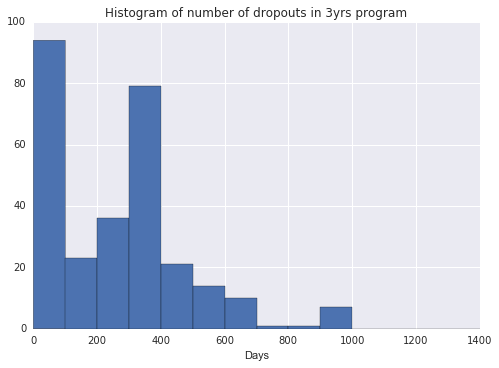

In [112]:
match_3yrs[match_3yrs.Dropout==1].length_of_match_in_days.hist(bins=14, range=[0, 1400])
plt.title("Histogram of number of dropouts in 3yrs program")
plt.xlabel("Days")

In [98]:
match_4yrs.length_years = match_4yrs.length_of_match_in_days / 365.0

/Applications/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [101]:
match_4yrs[match_4yrs.Dropout==1].length_years.hist()
plt.title("Histogram of number of dropouts in 4yrs program")
plt.xlabel("Years")

In [106]:
?match_df.hist()

## Prediciton without "N/A" attributes and Program Types - ONLY DEMOG traits

In [65]:
mentors_df.columns.values

array(['mentor_persona_id', 'Dropout', 'formal_close', 'prog_type_4yrs',
       'match_days_LT1yr', 'match_days_1to2yr', 'match_days_2to3yr',
       'match_days_3yrplus', 'racial_group_na', 'racial_group_asian',
       'racial_group_black', 'racial_group_hispanic', 'racial_group_white',
       'gender', 'age_at_match_lt20', 'age_at_match_20s',
       'age_at_match_30s', 'age_at_match_40s', 'age_at_match_50s',
       'age_at_match_60plus', 'career_na', 'career_accounting',
       'career_ads', 'career_achitecture', 'career_arts',
       'career_athletic', 'career_business', 'career_comm',
       'career_computer', 'career_consulting', 'career_educ',
       'career_engineer', 'career_finance', 'career_gov', 'career_health',
       'career_hr', 'career_hs', 'career_intl', 'career_law',
       'career_marketing', 'career_nonprofit', 'career_other',
       'career_sales', 'career_science', 'career_tech', 'career_trades',
       'have_children', 'marital_status', 'marital_status_divorced',
 

In [70]:
# Randomly shuffle the training data. Use same random seed to get same results every time.
mentors_df7 = mentors_df.copy()  # all features
train_df_shuffle = mentors_df7.sample(frac=1, random_state=0).reset_index(drop=True)

# Separate train labels
train_labels = [i for i in train_df_shuffle.Dropout]

# Drop labels from train data
train_df_shuffle.drop('Dropout', axis=1, inplace=True)
train_df_shuffle.drop('formal_close', axis=1, inplace=True)
train_df_shuffle.drop('mentor_persona_id', axis=1, inplace=True)
train_df_shuffle.drop('match_days_LT1yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_1to2yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_2to3yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_3yrplus', axis=1, inplace=True)
train_df_shuffle.drop('racial_group_na', axis=1, inplace=True)
train_df_shuffle.drop('career_na', axis=1, inplace=True)
train_df_shuffle.drop('marital_status', axis=1, inplace=True)
train_df_shuffle.drop('level_of_ed_na', axis=1, inplace=True)
train_df_shuffle.drop('parent_colleged_degree_na', axis=1, inplace=True)
train_df_shuffle.drop('hear_na', axis=1, inplace=True)
train_df_shuffle.drop('prog_type_4yrs', axis=1, inplace=True)
    

# Split the train data into training and dev datasets - about 2/3 & 1/3
# Total observations in mentors_df = 2,296
training_df =  train_df_shuffle[:1530]
dev_df = train_df_shuffle[1530:]

# Separate training and dev labels
training_labels =  train_labels[:1530]
dev_labels = train_labels[1530:]

In [81]:
# Decision Tree
print "Evaluating Decision Tree model ..."

# Create a Decision Tree model. 
DTmodel = DecisionTreeClassifier(criterion='entropy', max_depth=7)

# Fit the models and display the results.
start_time = time.time()
DTmodel.fit(training_df, training_labels)
end_time = time.time()
print "Decistion Tree model fitting time = %f seconds." % (end_time - start_time)

# Predict labels for dev data and calculate accuracy 
start_time = time.time()
yDTmodel = DTmodel.predict(dev_df)
end_time = time.time()
print "Decision Tree prediction time for dev data = %f seconds." % (end_time - start_time)

# Print goodness of fit measures
print "Accuracy on dev data for Decision Tree is = %f" % DTmodel.score(dev_df, dev_labels)
print "Classification Report\n", classification_report(dev_labels, yDTmodel)

Evaluating Decision Tree model ...
Decistion Tree model fitting time = 0.006323 seconds.
Decision Tree prediction time for dev data = 0.000979 seconds.
Accuracy on dev data for Decision Tree is = 0.601828
Classification Report
             precision    recall  f1-score   support

          0       0.44      0.67      0.53       255
          1       0.78      0.57      0.65       511

avg / total       0.66      0.60      0.61       766



In [82]:
features_importance = DTmodel.feature_importances_ 
features_names = training_df.columns.values
features_imp_list = []
for name, importance in zip(features_names, features_importance):
    features_imp_list.append([name,importance])
    
features_imp_list_sorted = sorted(features_imp_list, key=lambda x: x[1], reverse=True)

for name, importance in features_imp_list_sorted:
    if importance >= 0.00005:
        print name, ": %.4f" %(importance)

parent_colleged_degree_yes : 0.2026
career_business : 0.1133
parent_colleged_degree_no : 0.0865
career_educ : 0.0694
career_health : 0.0661
career_tech : 0.0604
marital_status_single : 0.0504
career_law : 0.0460
age_at_match_50s : 0.0442
have_children : 0.0398
hear_employer : 0.0385
level_of_ed_master : 0.0322
racial_group_black : 0.0315
level_of_ed_4yrCol : 0.0179
level_of_ed_phd : 0.0163
hear_friendfamily : 0.0139
gender : 0.0123
hear_other : 0.0111
hear_volunteerwebsite : 0.0092
hear_socialmedia : 0.0087
racial_group_hispanic : 0.0086
age_at_match_20s : 0.0079
hear_web : 0.0075
age_at_match_30s : 0.0057


In [83]:
from IPython.core.display import Image, display
from sklearn.externals.six import StringIO
from sklearn import tree
import pydotplus 

features_list = training_df.columns.values
dropout_list = ['Formal close', 'Dropout']

# Export the trained tree so we can look at it.
output_name = 'dropouts-decisiontree-wihtout-na.jpg'
dot_data = StringIO()
tree.export_graphviz(DTmodel, out_file=dot_data, feature_names=features_list, class_names=dropout_list, \
                     filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# If the export was successful, show the image.
if graph.write_jpg(output_name):
    print 'Output:', output_name
    display(Image(filename=output_name))  

Output: dropouts-decisiontree-wihtout-na.jpg


Percentage of termination by program types:  
Reason/4 years program/3 years program  
- None/ 11%/ 14%  
- Formal closure/ 7%/ 48%  
- Mentee cannot participate/ 33%/ 10%  
- Mentor cannot participate(dropout)/ 49%/ 22%  
- Program partnership ended/ 0%/ 6%  

## Next Steps

Next steps:  
- bootstrap methods to increase the number of data points in smaller groups for a fair model training (e.g. 4 years program, bootstrap formal closure data points) and re-run the decision tree models
- basic stats to investigate any significant mean difference of demographic attributes between 3 and 4 years program mentors who dropped out
- subsample of cohort 2012 to 2016 analysis: hypothesis being the 4 years program is fairly recent so not enough time for mentors to formally close in a 4 year program. With time, the % of mentors termination from formal closure may go up and be similar to 3 years program

In [ ]:
#mentors_df5 = mentors_df.copy()  # all features
#mentors_df5_4yrs = mentors_df5[mentors_df5.prog_type_4yrs==1]
#mentors_df5_3yrs = mentors_df5[mentors_df5.prog_type_4yrs==0]
#print mentors_df5_4yrs.shape
#print mentors_df5_3yrs.shape

## Bootstrapping to get equal group size of dropouts and formal closure in each program type

### a) 4-year program

#### Step 1: Bootstrapping formal closure to increase sample size from 166 to 1220 (same as dropouts)

In [143]:
mentors_df5_4yrs_formal = mentors_df5_4yrs[mentors_df5_4yrs.formal_close==1]
mentors_df5_4yrs_dropout = mentors_df5_4yrs[mentors_df5_4yrs.Dropout==1]
count_dropout_4yrs = mentors_df5_4yrs[mentors_df5_4yrs.Dropout == 1].Dropout.sum()
print count_dropout_4yrs
print mentors_df5_4yrs[mentors_df5_4yrs.formal_close == 1].formal_close.sum()


1220
166


In [144]:
mentors_df5_4yrs_formal_sample = mentors_df5_4yrs_formal.sample(count_dropout_4yrs, replace=True)

In [145]:
mentors_df6_4yrs_sample = mentors_df5_4yrs_dropout.append(mentors_df5_4yrs_formal_sample)

In [149]:
# For 4 years program
# Randomly shuffle the training data. Use same random seed to get same results every time.
train_df_shuffle = mentors_df6_4yrs_sample.sample(frac=1, random_state=0).reset_index(drop=True)

# Separate train labels
train_labels = [i for i in train_df_shuffle.Dropout]

# Drop labels from train data
train_df_shuffle.drop('Dropout', axis=1, inplace=True)
train_df_shuffle.drop('formal_close', axis=1, inplace=True)
train_df_shuffle.drop('mentor_persona_id', axis=1, inplace=True)
train_df_shuffle.drop('prog_type_4yrs', axis=1, inplace=True)
train_df_shuffle.drop('match_days_LT1yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_1to2yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_2to3yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_3yrplus', axis=1, inplace=True)
    

# Split the train data into training and dev datasets - about 2/3 & 1/3
# Total observations in mentors_df = 1,220 * 2 = 2,440
training_df_4yrs =  train_df_shuffle[:1625]
dev_df_4yrs = train_df_shuffle[1625:]

# Separate training and dev labels
training_labels_4yrs =  train_labels[:1625]
dev_labels_4yrs = train_labels[1625:]

#### Step 2: Decision tree for 4 year prog with equal group size sample

In [150]:
# Decision Tree
print "Evaluating Decision Tree model ..."

# Create a Decision Tree model. 
DTmodel = DecisionTreeClassifier(criterion='entropy', max_depth=5)

# Fit the models and display the results.
start_time = time.time()
DTmodel.fit(training_df_4yrs, training_labels_4yrs)
end_time = time.time()
print "Decistion Tree model fitting time = %f seconds." % (end_time - start_time)

# Predict labels for dev data and calculate accuracy 
start_time = time.time()
yDTmodel = DTmodel.predict(dev_df_4yrs)
end_time = time.time()
print "Decision Tree prediction time for dev data = %f seconds." % (end_time - start_time)

# Print goodness of fit measures
print "Accuracy on dev data for Decision Tree is = %f" % DTmodel.score(dev_df_4yrs, dev_labels_4yrs)
print "Classification Report\n", classification_report(dev_labels_4yrs, yDTmodel)

Evaluating Decision Tree model ...
Decistion Tree model fitting time = 0.120672 seconds.
Decision Tree prediction time for dev data = 0.010385 seconds.
Accuracy on dev data for Decision Tree is = 0.680982
Classification Report
             precision    recall  f1-score   support

          0       0.68      0.72      0.70       418
          1       0.69      0.63      0.66       397

avg / total       0.68      0.68      0.68       815



Observation: 
- Removed the effect of the previous unbalanced group size in which the dropout group (much larger group) was drowning the influence of the smaller group in the prediction model.  
- More equal accurary of predicting dropout or formal closure from the model.

In [152]:
features_importance = DTmodel.feature_importances_ 
features_names = training_df.columns.values
features_imp_list = []
for name, importance in zip(features_names, features_importance):
    features_imp_list.append([name,importance])
    
features_imp_list_sorted = sorted(features_imp_list, key=lambda x: x[1], reverse=True)

for name, importance in features_imp_list_sorted:
    if importance >= 0.005:
        print name, ": %.4f" %(importance)

career_ads : 0.1952
hear_socialmedia : 0.1101
level_of_ed_HS : 0.0770
racial_group_black : 0.0671
marital_status_widow : 0.0502
parent_colleged_degree_no : 0.0468
age_at_match_lt20 : 0.0427
age_at_match_40s : 0.0323
career_business : 0.0314
racial_group_white : 0.0281
age_at_match_30s : 0.0264
career_accounting : 0.0196
racial_group_asian : 0.0172
marital_status_married : 0.0145


Output: dropouts-decisiontree-4yrs-boots.jpg


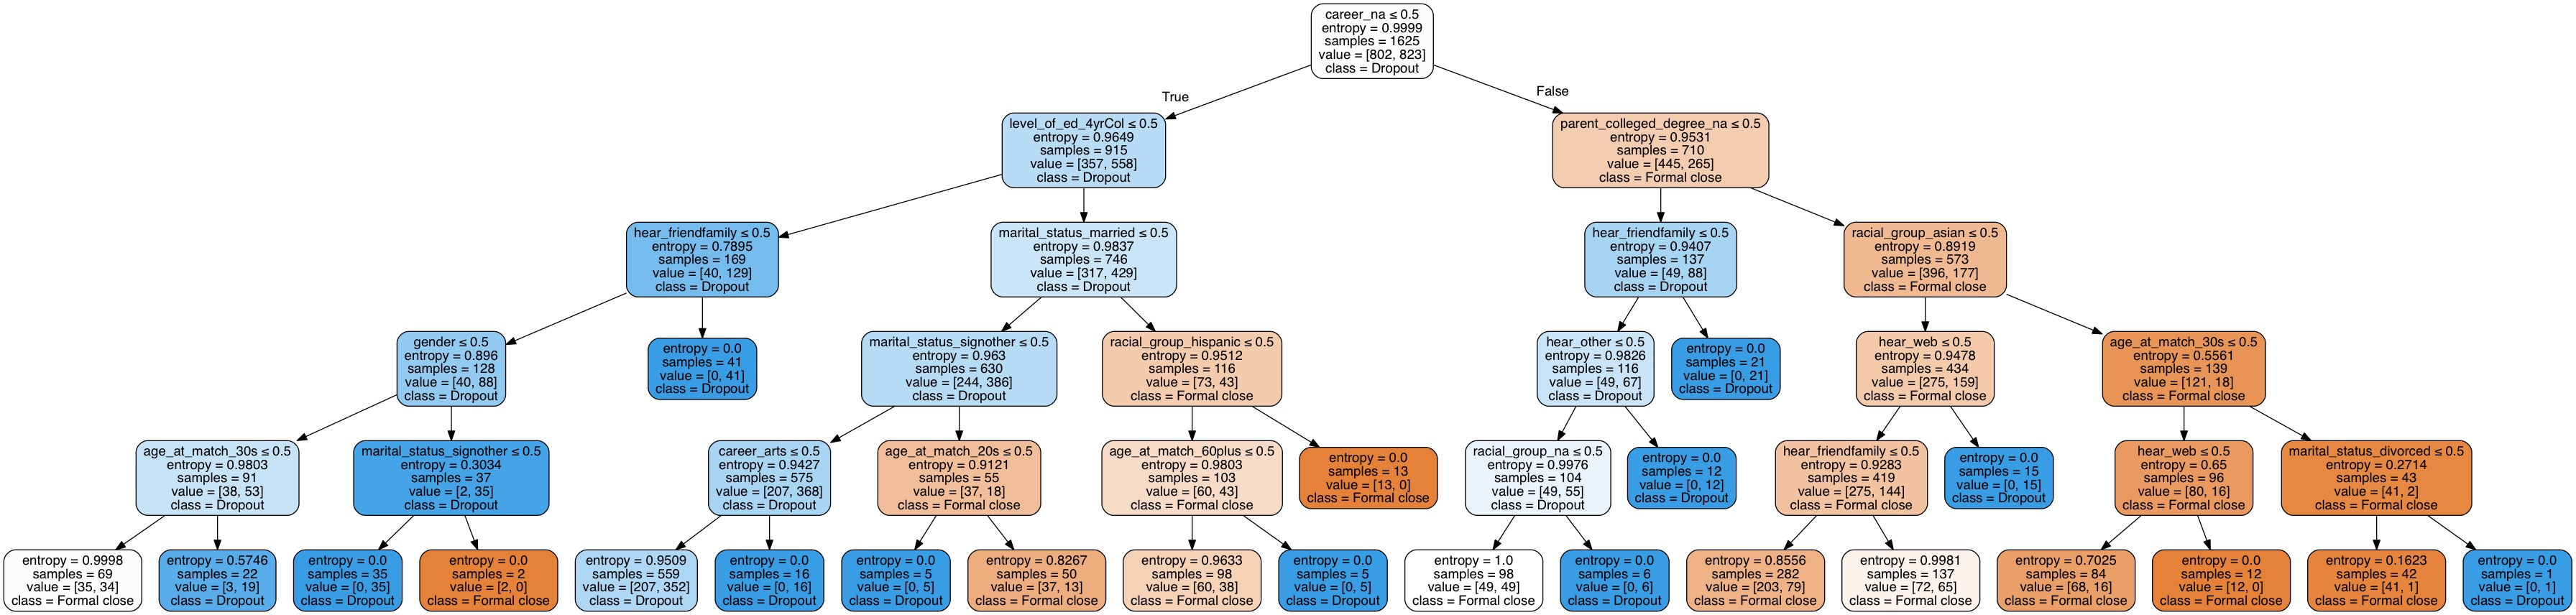

In [154]:
from IPython.core.display import Image, display
from sklearn.externals.six import StringIO
from sklearn import tree
import pydotplus 

features_list = training_df_4yrs.columns.values
dropout_list = ['Formal close', 'Dropout']

# Export the trained tree so we can look at it.
output_name = 'dropouts-decisiontree-4yrs-boots.jpg'
dot_data = StringIO()
tree.export_graphviz(DTmodel, out_file=dot_data, feature_names=features_list, class_names=dropout_list, \
                     filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# If the export was successful, show the image.
if graph.write_jpg(output_name):
    print 'Output:', output_name
    display(Image(filename=output_name))  

### b) 3-year program

#### Step 1: Bootstrapping dropout to increase sample size from  to  (same as formal closure)

In [157]:
mentors_df5_3yrs_formal = mentors_df5_3yrs[mentors_df5_3yrs.formal_close==1]
mentors_df5_3yrs_dropout = mentors_df5_3yrs[mentors_df5_3yrs.Dropout==1]
count_formal_3yrs = mentors_df5_3yrs[mentors_df5_3yrs.formal_close == 1].formal_close.sum()
print count_formal_3yrs
print mentors_df5_3yrs[mentors_df5_3yrs.Dropout == 1].Dropout.sum()

624
286


In [189]:
mentors_df5_3yrs_dropout_sample = mentors_df5_3yrs_dropout.sample(count_formal_3yrs, replace=True)

In [190]:
mentors_df6_3yrs_sample = mentors_df5_3yrs_formal.append(mentors_df5_3yrs_dropout_sample)

In [191]:
print len(mentors_df6_3yrs_sample)
print len(mentors_df5_3yrs_formal)
print len(mentors_df5_3yrs_dropout_sample)

1248
624
624


In [192]:
# For 3 years program
# Randomly shuffle the training data. Use same random seed to get same results every time.
train_df_shuffle = mentors_df6_3yrs_sample.sample(frac=1, random_state=0).reset_index(drop=True)

# Separate train labels
train_labels = [i for i in train_df_shuffle.Dropout]

# Drop labels from train data
train_df_shuffle.drop('Dropout', axis=1, inplace=True)
train_df_shuffle.drop('formal_close', axis=1, inplace=True)
train_df_shuffle.drop('mentor_persona_id', axis=1, inplace=True)
train_df_shuffle.drop('prog_type_4yrs', axis=1, inplace=True)
train_df_shuffle.drop('match_days_LT1yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_1to2yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_2to3yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_3yrplus', axis=1, inplace=True)
    

# Split the train data into training and dev datasets - about 2/3 & 1/3
# Total observations in mentors_df = 624 * 2 = 1,248
training_df_3yrs =  train_df_shuffle[:830]
dev_df_3yrs = train_df_shuffle[830:]

# Separate training and dev labels
training_labels_3yrs =  train_labels[:830]
dev_labels_3yrs = train_labels[830:]

#### Step 2: Decision Tree for 3-year program with equal group size sample

In [194]:
# Decision Tree
print "Evaluating Decision Tree model ..."

# Create a Decision Tree model. 
DTmodel = DecisionTreeClassifier(criterion='entropy', max_depth=6)

# Fit the models and display the results.
start_time = time.time()
DTmodel.fit(training_df_3yrs, training_labels_3yrs)
end_time = time.time()
print "Decistion Tree model fitting time = %f seconds." % (end_time - start_time)

# Predict labels for dev data and calculate accuracy 
start_time = time.time()
yDTmodel = DTmodel.predict(dev_df_3yrs)
end_time = time.time()
print "Decision Tree prediction time for dev data = %f seconds." % (end_time - start_time)

# Print goodness of fit measures
print "Accuracy on dev data for Decision Tree is = %f" % DTmodel.score(dev_df_3yrs, dev_labels_3yrs)
print "Classification Report\n", classification_report(dev_labels_3yrs, yDTmodel)

Evaluating Decision Tree model ...
Decistion Tree model fitting time = 0.003984 seconds.
Decision Tree prediction time for dev data = 0.000847 seconds.
Accuracy on dev data for Decision Tree is = 0.586124
Classification Report
             precision    recall  f1-score   support

          0       0.58      0.47      0.52       200
          1       0.59      0.69      0.64       218

avg / total       0.59      0.59      0.58       418



Observation: same as for the 4 year program - improvement with balancing the size of both groups.

In [195]:
features_importance = DTmodel.feature_importances_ 
features_names = training_df_3yrs.columns.values
features_imp_list = []
for name, importance in zip(features_names, features_importance):
    features_imp_list.append([name,importance])
    
features_imp_list_sorted = sorted(features_imp_list, key=lambda x: x[1], reverse=True)

for name, importance in features_imp_list_sorted:
    if importance >= 0.005:
        print name, ": %.4f" %(importance)

parent_colleged_degree_na : 0.4727
career_na : 0.0743
marital_status : 0.0502
age_at_match_40s : 0.0461
career_health : 0.0459
level_of_ed_na : 0.0444
racial_group_white : 0.0385
hear_employer : 0.0360
level_of_ed_phd : 0.0359
career_intl : 0.0282
career_science : 0.0242
hear_web : 0.0234
age_at_match_60plus : 0.0227
level_of_ed_2yrCol : 0.0200
have_children : 0.0196
age_at_match_30s : 0.0178


In [196]:
from IPython.core.display import Image, display
from sklearn.externals.six import StringIO
from sklearn import tree
import pydotplus 

features_list = training_df_3yrs.columns.values
dropout_list = ['Formal close', 'Dropout']

# Export the trained tree so we can look at it.
output_name = 'dropouts-decisiontree-3yrs-boots.jpg'
dot_data = StringIO()
tree.export_graphviz(DTmodel, out_file=dot_data, feature_names=features_list, class_names=dropout_list, \
                     filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# If the export was successful, show the image.
if graph.write_jpg(output_name):
    print 'Output:', output_name
    display(Image(filename=output_name))  

Output: dropouts-decisiontree-3yrs-boots.jpg


## Combining the bootstrapped samples for both 4 and 3 year programs

In [198]:
count_3yrs = len(mentors_df6_3yrs_sample) / 2
temp1 = mentors_df5_4yrs_dropout.sample(count_3yrs, replace=False)  # pick same number as in 3 year program
temp2 = mentors_df5_4yrs_formal_sample.sample(count_3yrs, replace=False)
mentors_df7_temp = mentors_df6_3yrs_sample.append(temp1)
mentors_df7 = mentors_df7_temp.append(temp2)

In [205]:
# For 3 years program
# Randomly shuffle the training data. Use same random seed to get same results every time.
train_df_shuffle = mentors_df7.sample(frac=1, random_state=0).reset_index(drop=True)

# Separate train labels
train_labels = [i for i in train_df_shuffle.Dropout]

# Drop labels from train data
train_df_shuffle.drop('Dropout', axis=1, inplace=True)
train_df_shuffle.drop('formal_close', axis=1, inplace=True)
train_df_shuffle.drop('mentor_persona_id', axis=1, inplace=True)
train_df_shuffle.drop('prog_type_4yrs', axis=1, inplace=True)
train_df_shuffle.drop('match_days_LT1yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_1to2yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_2to3yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_3yrplus', axis=1, inplace=True)
    

# Split the train data into training and dev datasets - about 2/3 & 1/3
# Total observations in mentors_df = 624 * 4 = 1,248
training_df =  train_df_shuffle[:1660]
dev_df = train_df_shuffle[1660:]

# Separate training and dev labels
training_labels =  train_labels[:1660]
dev_labels = train_labels[1660:]

In [206]:
# Decision Tree
print "Evaluating Decision Tree model ..."

# Create a Decision Tree model. 
DTmodel = DecisionTreeClassifier(criterion='entropy', max_depth=6)

# Fit the models and display the results.
start_time = time.time()
DTmodel.fit(training_df, training_labels)
end_time = time.time()
print "Decistion Tree model fitting time = %f seconds." % (end_time - start_time)

# Predict labels for dev data and calculate accuracy 
start_time = time.time()
yDTmodel = DTmodel.predict(dev_df)
end_time = time.time()
print "Decision Tree prediction time for dev data = %f seconds." % (end_time - start_time)

# Print goodness of fit measures
print "Accuracy on dev data for Decision Tree is = %f" % DTmodel.score(dev_df, dev_labels)
print "Classification Report\n", classification_report(dev_labels, yDTmodel)

Evaluating Decision Tree model ...
Decistion Tree model fitting time = 0.006859 seconds.
Decision Tree prediction time for dev data = 0.000838 seconds.
Accuracy on dev data for Decision Tree is = 0.627990
Classification Report
             precision    recall  f1-score   support

          0       0.64      0.59      0.62       422
          1       0.61      0.67      0.64       414

avg / total       0.63      0.63      0.63       836



In [207]:
features_importance = DTmodel.feature_importances_ 
features_names = training_df_3yrs.columns.values
features_imp_list = []
for name, importance in zip(features_names, features_importance):
    features_imp_list.append([name,importance])
    
features_imp_list_sorted = sorted(features_imp_list, key=lambda x: x[1], reverse=True)

for name, importance in features_imp_list_sorted:
    if importance >= 0.005:
        print name, ": %.4f" %(importance)

career_na : 0.2801
parent_colleged_degree_na : 0.2647
marital_status_signother : 0.0601
level_of_ed_na : 0.0522
hear_employer : 0.0422
racial_group_white : 0.0311
level_of_ed_4yrCol : 0.0305
hear_other : 0.0278
career_tech : 0.0256
hear_web : 0.0233
hear_na : 0.0220
age_at_match_50s : 0.0218
level_of_ed_2yrCol : 0.0213
age_at_match_60plus : 0.0181
level_of_ed_phd : 0.0137
marital_status_married : 0.0136
racial_group_na : 0.0125
hear_friendfamily : 0.0123
marital_status_divorced : 0.0112
marital_status_engaged : 0.0084
have_children : 0.0075


In [208]:
from IPython.core.display import Image, display
from sklearn.externals.six import StringIO
from sklearn import tree
import pydotplus 

features_list = training_df.columns.values
dropout_list = ['Formal close', 'Dropout']

# Export the trained tree so we can look at it.
output_name = 'dropouts-decisiontree-bothprog-boots.jpg'
dot_data = StringIO()
tree.export_graphviz(DTmodel, out_file=dot_data, feature_names=features_list, class_names=dropout_list, \
                     filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# If the export was successful, show the image.
if graph.write_jpg(output_name):
    print 'Output:', output_name
    display(Image(filename=output_name))  

Output: dropouts-decisiontree-bothprog-boots.jpg


# ---- END OF ANALYSIS ----

In [ ]:
import pandas as pd
import psycopg2

conn = psycopg2.connect(database="awesome", user = "awesome_admin",
password="w205.Awesome", host = "34.193.7.196", port="5432")
cur = conn.cursor()
cur.execute("select attribute1, attribute2, attribute3 from table_name")
df = pd.DataFrame(cur.fetchall(), columns=['instrument', 'price', 'date'])
df.to_csv('filename.csv')